# Correlation: generation params vs hallucination

This notebook analyzes outputs under `output/` to measure how generation parameters (CREATIVITY levels and LENGTH_WORDS) relate to hallucination.

Definition used here:
- **Hallucination rate** = 1 - mean(is_supported) across extracted claims for a prompt.

You can filter to LENGTH_WORDS=50 (the focus requested) using the `LENGTH_FILTER` variable below.


In [ ]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

OUTPUT_ROOT = Path('../output/longwiki-hybrid')
LENGTH_FILTER = None  # set to None to analyze all lengths


In [ ]:
def _read_jsonl(path):
    rows = []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

def load_run(run_dir):
    # generation metadata per prompt
    gen_rows = _read_jsonl(run_dir / 'generation.jsonl')
    gen = pd.DataFrame({
        'prompt': [r.get('prompt') for r in gen_rows],
        'creativity_level': [r.get('creativity_level') for r in gen_rows],
        'length_words': [r.get('length_words') for r in gen_rows],
        'task': [r.get('task') for r in gen_rows],
        'title': [r.get('title') for r in gen_rows],
    })

    # run-level metadata
    cfg = json.loads((run_dir / 'run_config.json').read_text(encoding='utf-8'))
    model_name = cfg.get('model_name')
    temperature = float(cfg.get('args', {}).get('temperature'))

    # claim-level evals
    claims = pd.read_csv(run_dir / 'output.csv')
    # ensure boolean
    claims['is_supported'] = claims['is_supported'].astype(str).str.lower().eq('true')

    # aggregate per prompt
    agg = (
        claims.groupby('prompt', as_index=False)
        .agg(
            n_claims=('is_supported', 'size'),
            support_rate=('is_supported', 'mean'),
        )
    )
    agg['hallucination_rate'] = 1.0 - agg['support_rate']

    # join
    df = gen.merge(agg, on='prompt', how='left')
    df['run_dir'] = run_dir.name
    df['model_name'] = model_name
    df['temperature'] = temperature
    return df


In [ ]:
run_dirs = [p for p in OUTPUT_ROOT.iterdir() if p.is_dir()]
run_dirs = sorted(run_dirs, key=lambda p: p.name)
len(run_dirs), run_dirs[:3]


(21,
 [PosixPath('../output/longwiki-hybrid/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.0'),
  PosixPath('../output/longwiki-hybrid/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.25'),
  PosixPath('../output/longwiki-hybrid/gemini-3-flash-preview__static_prompts_len150_mgemini-3-flash-preview_t0.5')])

In [ ]:
all_rows = []
for rd in run_dirs:
    try:
        all_rows.append(load_run(rd))
    except Exception as e:
        print(f'skipping {rd}: {e}')

df = pd.concat(all_rows, ignore_index=True)
df.shape


skipping ../output/longwiki-hybrid/gemini-3-flash-preview__static_prompts_len300_mgemini-3-flash-preview_t0.0: [Errno 2] No such file or directory: '../output/longwiki-hybrid/gemini-3-flash-preview__static_prompts_len300_mgemini-3-flash-preview_t0.0/output.csv'
skipping ../output/longwiki-hybrid/mistral-small-creative__static_prompts_len150_mmistral-small-creative_t0.75: [Errno 2] No such file or directory: '../output/longwiki-hybrid/mistral-small-creative__static_prompts_len150_mmistral-small-creative_t0.75/output.csv'
skipping ../output/longwiki-hybrid/mistral-small-creative__static_prompts_len300_mmistral-small-creative_t0.0: [Errno 2] No such file or directory: '../output/longwiki-hybrid/mistral-small-creative__static_prompts_len300_mmistral-small-creative_t0.0/generation.jsonl'


(540, 11)

## Summary tables

Focus on LENGTH_WORDS=50 by default (set `LENGTH_FILTER=None` to include all).


In [ ]:
df_f = df.copy()
if LENGTH_FILTER is not None:
    df_f = df_f[df_f['length_words'].isin(LENGTH_FILTER)]

summary = (
    df_f.groupby(['length_words', 'creativity_level'], as_index=False)
    .agg(
        n_prompts=('prompt', 'count'),
        hallucination_rate_mean=('hallucination_rate', 'mean'),
        hallucination_rate_median=('hallucination_rate', 'median'),
        support_rate_mean=('support_rate', 'mean'),
        n_claims_mean=('n_claims', 'mean'),
    )
)
summary.sort_values(['length_words', 'creativity_level'])


,length_words,creativity_level,n_prompts,hallucination_rate_mean,hallucination_rate_median,support_rate_mean,n_claims_mean
0,50,FACTUAL,128,0.678750,0.670068,0.321250,35.708333
1,50,HYBRID,48,0.694688,0.666667,0.305312,38.347826
2,50,VERY_CREATIVE,64,0.818154,0.833333,0.181846,35.927273
3,150,FACTUAL,112,0.626731,0.580208,0.373269,44.481481
4,150,HYBRID,42,0.687293,0.687838,0.312707,43.825000
5,150,VERY_CREATIVE,56,0.781115,0.800000,0.218885,44.580000
6,300,FACTUAL,48,0.798334,0.825558,0.201666,68.142857
7,300,HYBRID,18,0.791728,0.760952,0.208272,72.562500
8,300,VERY_CREATIVE,24,0.834290,0.854025,0.165710,72.111111


In [ ]:
# Ordre fixe des classes de créativité
CREATIVITY_ORDER = ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']
df['creativity_level'] = pd.Categorical(df['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_f' in globals():
    df_f['creativity_level'] = pd.Categorical(df_f['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_mg' in globals():
    df_mg['creativity_level'] = pd.Categorical(df_mg['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)
if 'df_mg_f' in globals():
    df_mg_f['creativity_level'] = pd.Categorical(df_mg_f['creativity_level'], categories=CREATIVITY_ORDER, ordered=True)


**Note:** Les graphiques utilisent l'ordre FIXE des classes de créativité: FACTUAL → HYBRID → VERY_CREATIVE.


In [ ]:
# Pivot view for quick comparison
pivot = summary.pivot(index='creativity_level', columns='length_words', values='hallucination_rate_mean')
pivot


length_words,50,150,300
creativity_level,,,
FACTUAL,0.678750,0.626731,0.798334
HYBRID,0.694688,0.687293,0.791728
VERY_CREATIVE,0.818154,0.781115,0.834290


## Correlation analysis

- Pearson between LENGTH_WORDS and hallucination_rate (numeric).
- Spearman between creativity rank and hallucination_rate (ordinal encoding).


In [ ]:
df_corr = df_f.dropna(subset=['hallucination_rate', 'length_words', 'creativity_level']).copy()

# numeric correlation with length_words
pearson_len = df_corr[['length_words', 'hallucination_rate']].corr(method='pearson').iloc[0,1]

# ordinal encoding for creativity (order assumed)
creativity_order = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
df_corr['creativity_rank'] = df_corr['creativity_level'].map(creativity_order)
spearman_creativity = df_corr[['creativity_rank', 'hallucination_rate']].corr(method='spearman').iloc[0,1]

pearson_len, spearman_creativity


(np.float64(0.12792994313809206), np.float64(0.2649930262896565))

## Optional: split by model and temperature


In [ ]:
by_model = (
    df_f.groupby(['model_name', 'temperature', 'length_words', 'creativity_level'], as_index=False)
    .agg(
        n_prompts=('prompt', 'count'),
        hallucination_rate_mean=('hallucination_rate', 'mean'),
    )
)
by_model.sort_values(['model_name', 'temperature', 'length_words', 'creativity_level']).head(20)


,model_name,temperature,length_words,creativity_level,n_prompts,hallucination_rate_mean
0,gemini-3-flash-preview,0.00,50,FACTUAL,16,0.558399
1,gemini-3-flash-preview,0.00,50,HYBRID,6,0.614680
2,gemini-3-flash-preview,0.00,50,VERY_CREATIVE,8,0.790233
3,gemini-3-flash-preview,0.00,150,FACTUAL,16,0.494311
4,gemini-3-flash-preview,0.00,150,HYBRID,6,0.623301
5,gemini-3-flash-preview,0.00,150,VERY_CREATIVE,8,0.770231
6,gemini-3-flash-preview,0.25,50,FACTUAL,16,0.607364
7,gemini-3-flash-preview,0.25,50,HYBRID,6,0.626953
8,gemini-3-flash-preview,0.25,50,VERY_CREATIVE,8,0.795656
9,gemini-3-flash-preview,0.25,150,FACTUAL,16,0.497779


## Comparaison des modèles (Mistral vs Gemini)

Ces graphiques comparent directement les deux familles de modèles.


In [ ]:
# Filtrer les deux modèles (ajuste si d'autres variantes existent)
import matplotlib.pyplot as plt
import seaborn as sns
model_mask = df['model_name'].str.contains('mistral', case=False) | df['model_name'].str.contains('gemini', case=False)
df_mg = df[model_mask].copy()
df_mg['model_family'] = df_mg['model_name'].apply(lambda x: 'mistral' if 'mistral' in x.lower() else 'gemini')

# Appliquer le même filtre de longueur si défini
df_mg_f = df_mg.copy()
if LENGTH_FILTER is not None:
    df_mg_f = df_mg_f[df_mg_f['length_words'].isin(LENGTH_FILTER)]


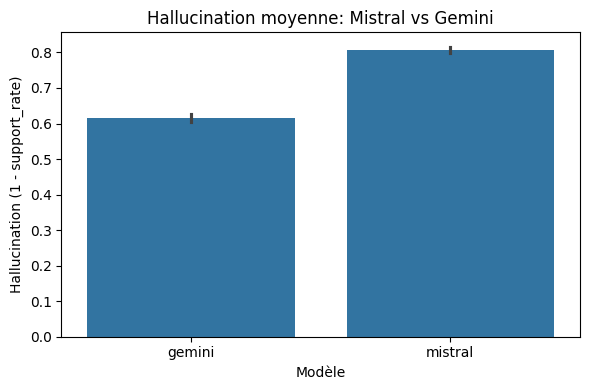

In [ ]:
# 1) Barplot: hallucination moyenne par modèle (toutes créativités)
plt.figure(figsize=(6,4))
sns.barplot(data=df_mg_f, x='model_family', y='hallucination_rate', estimator='mean', errorbar='se')
plt.title('Hallucination moyenne: Mistral vs Gemini')
plt.xlabel('Modèle')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


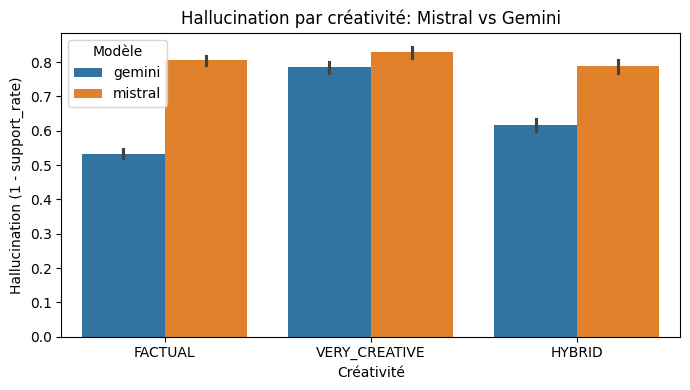

In [ ]:
# 2) Barplot: hallucination par créativité et modèle
plt.figure(figsize=(7,4))
sns.barplot(data=df_mg_f, x='creativity_level', y='hallucination_rate', hue='model_family', estimator='mean', errorbar='se')
plt.title('Hallucination par créativité: Mistral vs Gemini')
plt.xlabel('Créativité')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


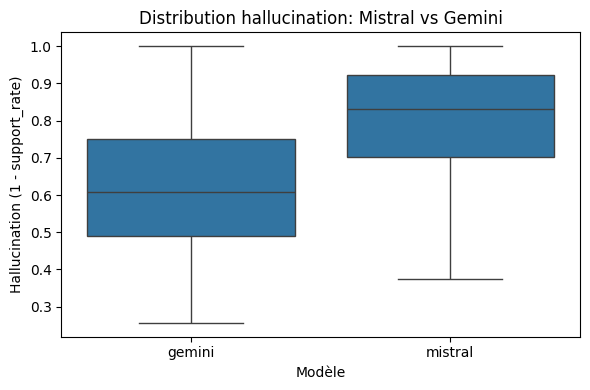

In [ ]:
# 3) Boxplot: distribution par modèle
plt.figure(figsize=(6,4))
sns.boxplot(data=df_mg_f, x='model_family', y='hallucination_rate')
plt.title('Distribution hallucination: Mistral vs Gemini')
plt.xlabel('Modèle')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


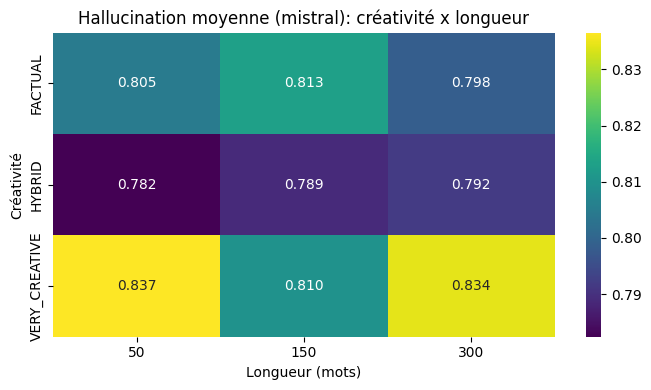

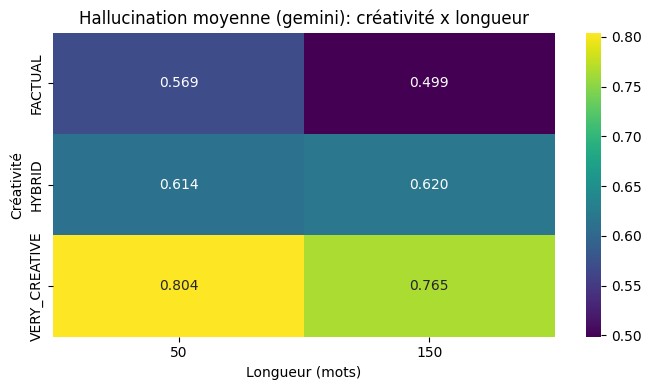

In [ ]:
# 4) Heatmap: créativité x longueur par modèle (moyenne)
heat_mg = (
    df_mg.groupby(['model_family', 'creativity_level', 'length_words'], as_index=False)
    .agg(hallucination_rate_mean=('hallucination_rate', 'mean'))
)
for mf in ['mistral', 'gemini']:
    hm = heat_mg[heat_mg['model_family'] == mf]
    hm_p = hm.pivot(index='creativity_level', columns='length_words', values='hallucination_rate_mean')
    plt.figure(figsize=(7,4))
    sns.heatmap(hm_p, annot=True, fmt='.3f', cmap='viridis')
    plt.title(f'Hallucination moyenne ({mf}): créativité x longueur')
    plt.xlabel('Longueur (mots)')
    plt.ylabel('Créativité')
    plt.tight_layout()
    plt.show()


## Graphiques supplémentaires: température et tâche


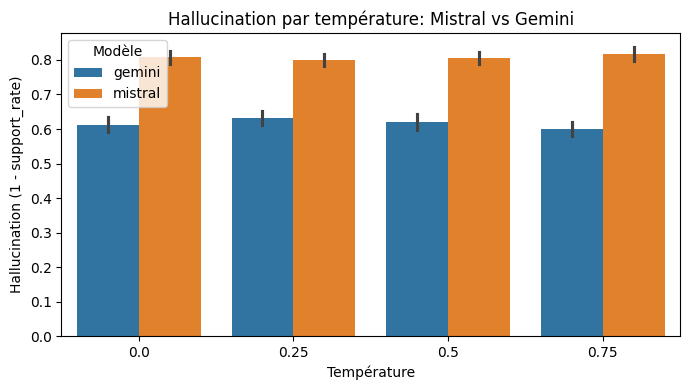

In [ ]:
# Filtre Mistral vs Gemini déjà défini dans df_mg / df_mg_f
# 1) Température: comparaison par modèle
plt.figure(figsize=(7,4))
sns.barplot(data=df_mg, x='temperature', y='hallucination_rate', hue='model_family', estimator='mean', errorbar='se')
plt.title('Hallucination par température: Mistral vs Gemini')
plt.xlabel('Température')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


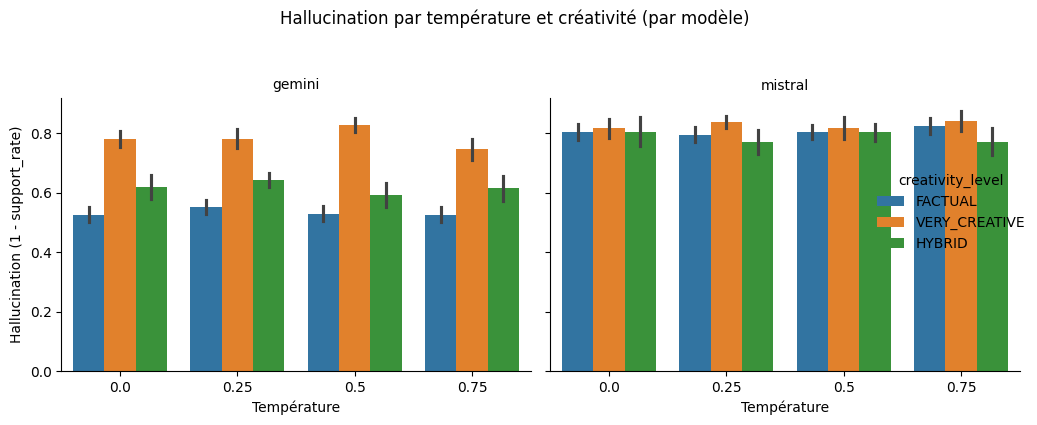

In [ ]:
# 2) Température + créativité: facettes par modèle
g = sns.catplot(
    data=df_mg,
    x='temperature', y='hallucination_rate',
    hue='creativity_level', col='model_family',
    kind='bar', estimator='mean', errorbar='se',
    height=4, aspect=1.1
)
g.set_titles('{col_name}')
g.set_axis_labels('Température', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Hallucination par température et créativité (par modèle)', y=1.05)
plt.tight_layout()
plt.show()


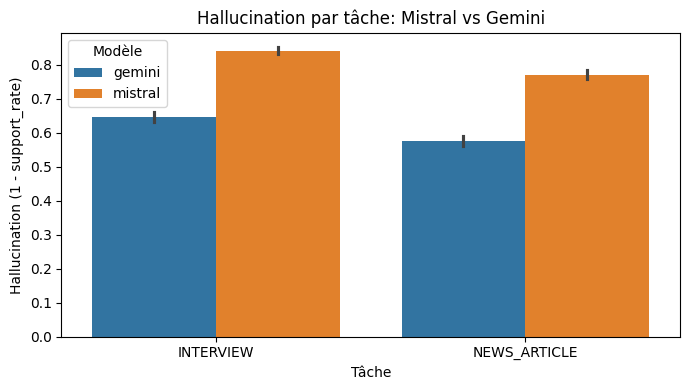

In [ ]:
# 3) Par tâche (INTERVIEW vs NEWS_ARTICLE, etc.)
plt.figure(figsize=(7,4))
sns.barplot(data=df_mg_f, x='task', y='hallucination_rate', hue='model_family', estimator='mean', errorbar='se')
plt.title('Hallucination par tâche: Mistral vs Gemini')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


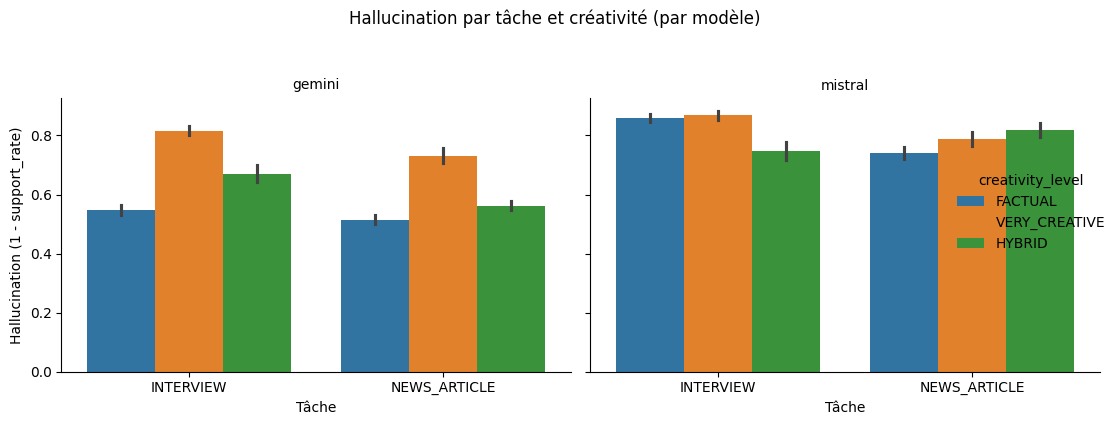

In [ ]:
# 4) Par tâche + créativité (facettes par modèle)
g = sns.catplot(
    data=df_mg_f,
    x='task', y='hallucination_rate',
    hue='creativity_level', col='model_family',
    kind='bar', estimator='mean', errorbar='se',
    height=4, aspect=1.2
)
g.set_titles('{col_name}')
g.set_axis_labels('Tâche', 'Hallucination (1 - support_rate)')
g.fig.suptitle('Hallucination par tâche et créativité (par modèle)', y=1.05)
plt.tight_layout()
plt.show()


## Corrélations créativité ↔ hallucination


In [ ]:
# Corrélations avec créativité (ordinal) et hallucination
creativity_order = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
df_corr2 = df_f.dropna(subset=['hallucination_rate', 'creativity_level']).copy()
df_corr2['creativity_rank'] = df_corr2['creativity_level'].map(creativity_order)

pearson_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='pearson').iloc[0,1]
spearman_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='spearman').iloc[0,1]
kendall_creativity = df_corr2[['creativity_rank', 'hallucination_rate']].corr(method='kendall').iloc[0,1]

pearson_creativity, spearman_creativity, kendall_creativity


(np.float64(0.2851031358479927),
 np.float64(0.2649930262896565),
 np.float64(0.21316571610613577))

In [ ]:
# Graphique: classes créatives vs score d'hallucination (moyenne + IC)
plt.figure(figsize=(7,4))
sns.pointplot(data=df_f, x='creativity_level', y='hallucination_rate', errorbar='se')
plt.title('Score d'hallucination par classe de créativité')
plt.xlabel('Créativité')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


SyntaxError: unterminated string literal (detected at line 4) (3358884821.py, line 4)

## Graphiques par tâche


In [ ]:
# 1) Hallucination moyenne par tâche
plt.figure(figsize=(7,4))
sns.barplot(data=df_f, x='task', y='hallucination_rate', estimator='mean', errorbar='se')
plt.title('Hallucination moyenne par tâche')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


In [ ]:
# 2) Distribution par tâche
plt.figure(figsize=(7,4))
sns.boxplot(data=df_f, x='task', y='hallucination_rate')
plt.title('Distribution hallucination par tâche')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.tight_layout()
plt.show()


In [ ]:
# 3) Tâche x créativité
plt.figure(figsize=(8,4))
sns.barplot(data=df_f, x='task', y='hallucination_rate', hue='creativity_level', estimator='mean', errorbar='se')
plt.title('Hallucination par tâche et créativité')
plt.xlabel('Tâche')
plt.ylabel('Hallucination (1 - support_rate)')
plt.legend(title='Créativité')
plt.tight_layout()
plt.show()


In [ ]:
# 4) Heatmap: tâche x créativité (moyenne)
heat_task = (
    df_f.groupby(['task', 'creativity_level'], as_index=False)
    .agg(hallucination_rate_mean=('hallucination_rate', 'mean'))
)
heat_task_p = heat_task.pivot(index='task', columns='creativity_level', values='hallucination_rate_mean')
plt.figure(figsize=(7,4))
sns.heatmap(heat_task_p, annot=True, fmt='.3f', cmap='viridis')
plt.title('Hallucination moyenne (tâche x créativité)')
plt.xlabel('Créativité')
plt.ylabel('Tâche')
plt.tight_layout()
plt.show()
